In [2]:
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plta
import os
os.environ['VXM_BACKEND'] = 'pytorch'
from voxelmorph.torch import networks
import voxelmorph as vxm
from tqdm.notebook import trange
from tqdm.notebook import tqdm
import nibabel as nib
import imageio
from matplotlib import pyplot as plt
import pathlib
from torch.utils.data import DataLoader,Dataset
from dataset import FiberDatasetDir, center_crop

In [86]:
sub1 = np.load('/data04/junyi/tmp/data0000.npz')['AF']

In [2]:
import subprocess
def join_ABCD_seg(raw_path:pathlib.Path):
    name = raw_path.name
    # data = nib.load(str(raw_path/'SegmentationMap_GMWMCSF.nii.gz')).get_fdata()
    processed_path = pathlib.Path('/data04/junyi/Datasets/PPMI_Reg/data/DWI')/name
    mat2MNI = processed_path/f'FA_2_MNI.mat'
    subprocess.run(f'cp {str(raw_path/"SegmentationMap_GMWMCSF.nii.gz")} {str(processed_path/"SegmentationMap_GMWMCSF_MNI.nii.gz")}', shell=True)
    # subprocess.run(f'flirt -in {str(raw_path/"SegmentationMap_GMWMCSF.nii.gz")} -ref {str(processed_path)}/FA.nii.gz -out {str(processed_path/"SegmentationMap_GMWMCSF_MNI.nii.gz")} -applyxfm -init {mat2MNI} -interp nearestneighbour', shell=True)
raw_path_list = pathlib.Path('/data04/junyi/Datasets/PPMI_Reg/data/tissueSeg/').iterdir()
for raw_path in raw_path_list:
    if raw_path.is_dir():
        join_ABCD_seg(raw_path)
    

In [3]:
backbone_tracts = ['AF', 'ATR', 'CA', 'CC',
                   'CG', 'CST', 'FPT', 'FX', 'ICP', 'IFO', 'ILF', 'MCP', 'MLF', 'OR', 'POPT', 'SCP',
                   'SLF_I', 'SLF_II', 'SLF_III', 'STR',
                   'ST_FO', 'ST_OCC', 'ST_PAR', 'ST_POSTC', 'ST_PREC', 'ST_PREF', 'ST_PREM',
                   'T_OCC', 'T_PAR', 'T_POSTC', 'T_PREC', 'T_PREF', 'T_PREM', 'UF']


In [6]:
def crop(x,indice_down, indice_up):
    x = x.astype(np.float32)
    return x[indice_down[0]:indice_up[0],indice_down[1]:indice_up[1],indice_down[2]:indice_up[2]]
class FiberDatasetDir(Dataset):
    def __init__(self, img_data_dir: pathlib.Path, transform=None, ):

        self.img_data_dir = sorted(list(pathlib.Path(img_data_dir).iterdir()))[:2]
        self.transform = transform
        tmp = nib.load(list(self.img_data_dir[0].glob('**/FA_MNI*'))[0])
        self.config = (tmp.affine,tmp.header)
        self.shape = tmp.get_fdata().shape
        self.indice_down = np.array(self.shape)//2-np.array([128//2, 160//2, 128//2])
        self.indice_up =(np.array(self.shape)//2)+np.array([128//2, 160//2, 128//2])

    def __len__(self):
        return len(self.img_data_dir)

    def __getitem__(self, idx):
        images_dir_path = self.img_data_dir[idx]
        struct_dict = {}
        indice_down = np.array(self.shape)//2-np.array([128//2, 160//2, 128//2])
        indice_up =(np.array(self.shape)//2)+np.array([128//2, 160//2, 128//2])
        FA_path = sorted(list(images_dir_path.glob('**/FA_MNI*')))[0]
        struct_dict['FA'] = self.transform(nib.load(FA_path).get_fdata()[::-1],indice_down,indice_up)[np.newaxis, ...]
            

        for tract in backbone_tracts:
            TOM_path = sorted(list((images_dir_path/'T1w/Diffusion/tractseg_output/TOM_new/').glob(f'{tract}.nii.gz')))[0]
            struct_dict[tract] = self.transform(nib.load(TOM_path).get_fdata()[::-1],indice_down,indice_up).transpose(-1,0,1,2)
        
        return struct_dict
dataset = FiberDatasetDir('/data01/junyi/datasets/HCP_100', center_crop)

In [3]:
tract = 'CA'
vol_shape = (128, 160, 128)
enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]
atlas = torch.empty(3, *vol_shape)
TOM_models = {}
# snapshot_path = f'/data04/junyi/models/models_sep/{tract}_trained_{tract}.pt'
snapshot_path = '/data04/junyi/models/whole_model.pt'

model_state = torch.load(snapshot_path,map_location='cpu')["MODEL_STATE"]


In [3]:

def center_padding(x,indice_down,indice_up,raw_shape):
    if x.ndim==4:
        zeros = np.zeros((*raw_shape,x.shape[-1]))
    if x.ndim==3:
        zeros = np.zeros(raw_shape)
    zeros[indice_down[0]:indice_up[0],indice_down[1]:indice_up[1],indice_down[2]:indice_up[2]] = x
    return zeros

In [8]:

OR = nib.load('/data04/junyi/Datasets/datasets/HCP_100/100307/T1w/Diffusion/tractseg_output/TOM_new/OR.nii.gz')
for tract in backbone_tracts:
    snapshot_path = f'/data04/junyi/models/models_sep/{tract}_trained_{tract}.pt'
    model_state = torch.load(snapshot_path,map_location='cpu')["MODEL_STATE"]
    atlas = model_state['atlas'].permute(1,2,3,0).numpy()
    nib.save(nib.Nifti1Image(atlas, OR.affine),f'outputs/{tract}_atlas.nii.gz')

In [ ]:
snapshot_path = '/data04/junyi/models/AF_trained_AF.pt'
model_state = torch.load(snapshot_path,map_location='cpu')["MODEL_STATE"]
atlas = model_state['FA_model._orig_mod.atlas']
OR = nib.load('/data04/junyi/Datasets/datasets/HCP_100/100307/T1w/Diffusion/tractseg_output/TOM_new/OR.nii.gz')
for tract in backbone_tracts:
    atlas = model_state[f'TOM_models.{tract}.atlas'].permute(1,2,3,0).numpy()
    nib.save(nib.Nifti1Image(atlas, OR.affine),f'outputs/{tract}_atlas.nii.gz')

In [73]:
model_state['flow_multi.main.bias']

tensor([0.0248, 0.0953, 0.0473])

In [100]:
model.load_state_dict(params,assign=True)
model.eval()
total_num = len(backbone_tracts)
fig = plt.figure(figsize=(100,100))
with torch.no_grad():
    for i,tract in enumerate(backbone_tracts):
        atlas = model.TOM_models[tract].atlas
        atlas = atlas.abs().permute(2,1,3,0)
        atlas/=(atlas.max()-atlas.min())
        ax = fig.add_subplot(total_num//5+1,5,i+1)
        ax.imshow(atlas[:,:,50],origin='lower')
        ax.set_title(tract,fontsize=50)
        plt.axis('off')
fig.tight_layout()

In [ ]:
dataset = FiberDatasetDir(pathlib.Path('/data01/junyi/datasets/HCP_100'),crop)


In [ ]:
nib.save(nib.Nifti1Image(model.TOM_models.AF.atlas.detach().squeeze().permute(1,2,3,0).numpy()[::-1], dataset.config[0], dataset.config[1]),f'AFatlas1.nii.gz')


In [ ]:
nib.save(nib.Nifti1Image(model.FA_model.atlas.detach().squeeze().numpy()[::-1], dataset.config[0], dataset.config[1]),f'atlas100FA.nii.gz')

In [ ]:
model.FA_model.atlas.squeeze().shape

torch.Size([128, 160, 128])

In [ ]:
%env CUDA_VISIBLE_DEVICES=0,1

env: CUDA_VISIBLE_DEVICES=0,1


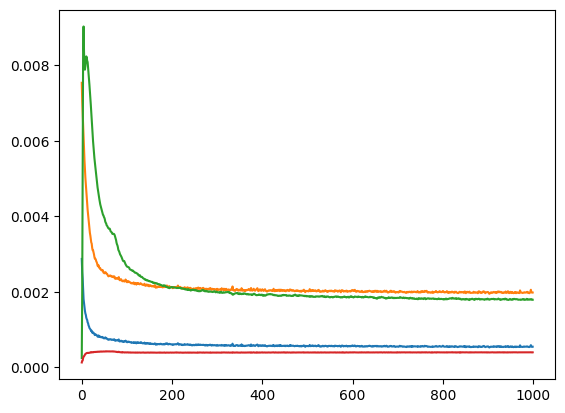

In [ ]:
plt.plot(snapshot['LOSS_HIS'])

In [ ]:
def _run_batch(model,optimizer,source,target):
    loss_funcs, loss_weights= _set_loss_function(model)
    optimizer.zero_grad()
    y_pred = model(source)
    loss = torch.stack([loss_funcs[i](target[i],y_pred[i])*loss_weights[i] for i in range(len(loss_weights))])
    loss.sum().backward()
    optimizer.step( )
    torch.cuda.empty_cache()
    return loss

def _set_loss_function(model):
    image_loss_func = nn.MSELoss()
    # orient_loss_func = nn.CosineSimilarity()
    # pos_loss_func = lambda y_true, y_pred: 1-torch.mean(orient_loss_func(y_true,y_pred))
    # neg_loss_func = lambda _,y_pred: 1-torch.mean(image_loss_func(y_pred, torch.stack([self.model.module.atlas for _ in range(y_pred.shape[0])])))
    pos_loss_func = lambda _,y_pred: image_loss_func(y_pred, torch.stack([model.FA_model.atlas for _ in range(y_pred.shape[0])]))
    neg_loss_func = lambda y_true_dict,y_pred_dict: torch.mean(torch.stack([image_loss_func(y_pred,y_true_dict[key]) for key,y_pred in y_pred_dict.items()]))
    mean_flow_loss = lambda _,y_pred: torch.square(y_pred).mean()
    loss_funcs = [pos_loss_func,neg_loss_func,mean_flow_loss, vxm.losses.Grad('l2', loss_mult=2).loss]
    loss_weights = [0.5, 0.5, 0.1, 0.01]
    return loss_funcs, loss_weights


In [ ]:
dataset = FiberDatasetDir(pathlib.Path('/data01/junyi/datasets/HCP_100'),crop)
# data = next(iter(DataLoader(dataset,batch_size=1,num_workers=8)))

In [94]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def plot_grid(grid, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = grid.transpose(1,2,0)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()
    # ax.set_xticks([])
    # ax.set_yticks([])
    

In [ ]:
flow =nib.load('/data01/junyi/results/tracts_related/flow100_alltracts/whole/SUB000.nii.gz').get_fdata()

In [98]:
data = np.load('data.npy')
flow = data[...,0]
x,y,z = (data[...,i,1] for i in range(3))
# sort by the x position, then the y position
order = np.lexsort((y, x))
flow, x, y, z = flow[order], x[order], y[order], z[order]

In [99]:
delta = 0.05
x_mean,y_mean,z_mean = 0.8, 0.5 ,0.9
mask = (x<(x_mean+delta) )* (x> (x_mean-delta)) * (y<(y_mean+delta)) * (y> (y_mean-delta)) 
flow = torch.from_numpy(flow[mask])

In [109]:
flow.shape

torch.Size([202, 3])

In [113]:
nablaz = torch.gradient(flow)[0]

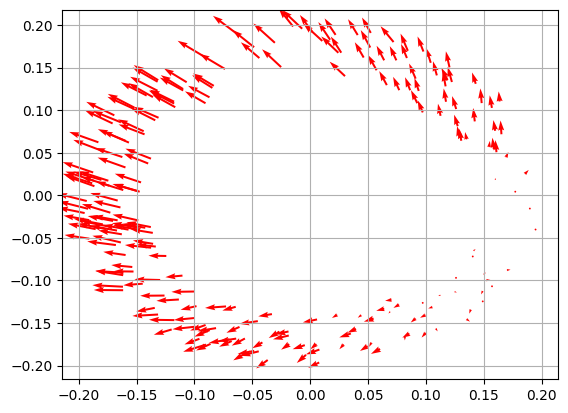

In [59]:
base = 0.98
threshold = 0.01
mask = (x>base) * (x<(base+threshold))
grid = np.stack(np.meshgrid(y[mask],z[mask]))
# generate a matrix which diagnal is the flow's last dimension
raw = np.zeros((mask.sum(),mask.sum(),2))
for i in range(mask.sum()):
    raw[i,i] = flow[mask][i,1:]
# np.diag_indices_from(flow[mask])
# flow = np.diagonal(flow[mask])
raw = raw.transpose(2,0,1)
# draw the flow vector on the each point (y,z)
fig, ax = plt.subplots()
# plot_grid(grid, ax=ax, color="black")
plt.quiver(y[mask],z[mask],flow[mask][:,1],flow[mask][:,2],color='r')
plt.grid()

In [34]:
x,y = x[::800,],y[::800,]
np.stack(np.meshgrid(x,y),0)

array([[[-0.9998875 , -0.96423936, -0.9394292 , ...,  0.9406753 ,
          0.96232265,  0.99194497],
        [-0.9998875 , -0.96423936, -0.9394292 , ...,  0.9406753 ,
          0.96232265,  0.99194497],
        [-0.9998875 , -0.96423936, -0.9394292 , ...,  0.9406753 ,
          0.96232265,  0.99194497],
        ...,
        [-0.9998875 , -0.96423936, -0.9394292 , ...,  0.9406753 ,
          0.96232265,  0.99194497],
        [-0.9998875 , -0.96423936, -0.9394292 , ...,  0.9406753 ,
          0.96232265,  0.99194497],
        [-0.9998875 , -0.96423936, -0.9394292 , ...,  0.9406753 ,
          0.96232265,  0.99194497]],

       [[-0.00226905, -0.00226905, -0.00226905, ..., -0.00226905,
         -0.00226905, -0.00226905],
        [ 0.08874654,  0.08874654,  0.08874654, ...,  0.08874654,
          0.08874654,  0.08874654],
        [ 0.12726873,  0.12726873,  0.12726873, ...,  0.12726873,
          0.12726873,  0.12726873],
        ...,
        [-0.19008057, -0.19008057, -0.19008057, ..., -

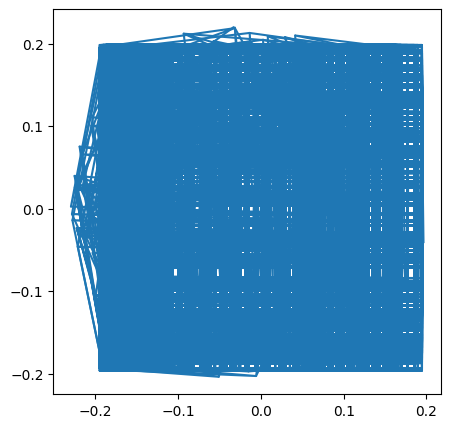

In [63]:
# x,y = torch.meshgrid([torch.arange(128),torch.arange(160)],indexing='ij')

fig , axes = plt.subplots(1,1,figsize=(5,5))
axes = [axes]
for i, flows in enumerate([flow]):
    # grid_shift = nn.functional.interpolate((torch.from_numpy(flows[...,45,:2]).permute(-1,0,1)+torch.stack([x,y])),scale_factor=(0.2),mode='linear')
    plot_grid(np.stack(np.meshgrid(y[mask],z[mask]))+0.1*raw,axes[i])
    # axes[i].set_title(backbone_tracts[i],size=30)
    if i >=33:
        break
# plt.axis('off')
plt.savefig('abc.png')